# Neural Network for Text Sentiment Analysis

This notebook demonstrates a complete pipeline for a sentiment prediction model using textual input. The steps include data preprocessing, feature extraction, model training, and evaluation. The key sections are:
1. Importing necessary libraries
2. Loading and exploring the data
3. Preprocessing and feature engineering
4. Building and training the model
5. Evaluating the model
6. Saving predictions and results

## Importing Libraries
We begin by importing the necessary libraries for data manipulation, visualization, natural language processing, and building a neural network.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [ ]:
large_train = "./data//424_F2024_Final_PC_large_train_v1.csv"
test_path = "./data/424_F2024_Final_PC_test_without_response_v1.csv"
model_path = "my_model.h5"

df_train = pd.read_csv(large_train)
df_test = pd.read_csv(test_path)

In [3]:
df_train.sample(5)

rating  year_review           firm            job_title  \
283563       3         2018         Oracle                        
408546       5         2016            PwC    Senior Associate    
369588       4         2021  Goldman-Sachs           Strategist   
253300       4         2021     McDonald-s   Mcdonalds Fry Cook   
132776       2         2020       Deloitte    Senior Consultant   

                                                 headline  \
283563                                      Large company   
408546  They have great benefits and really help grow ...   
369588                  Good company to start your career   
253300                          It was ok for a first job   
132776                                 Not a good company   

                                                     pros  \
283563         large company with impressive market share   
408546  Great career growth, travel opportunities, and...   
369588  Good Perks, Culcure for junior to grow, Good M...   
253300                   decent hours and good management   
132776             Nothing much to say about this company   

                                                     cons  
283563   large company more focused on margin than profit  
408546  Big company and a lot of red tape to get throu...  
369588           Benefit is not comparable to other banks  
253300                         low opportunity to move up  
132776                           Not a good place to work

In [4]:
df_test.sample(5)


rating  year_review             firm                     job_title  \
24179     NaN         2017       J-P-Morgan             Software Engineer   
25271     NaN         2017             Citi            Anonymous Employee   
76017     NaN         2017              IBM              Business Analyst   
54714     NaN         2021               EY   Advisory Senior Consultant    
41838     NaN         2017  British-Airways                   PMO Manager   

                                              headline  \
24179                                 Unjust Dismissal   
25271  Former Corporate Banking Executive at Citigroup   
76017                                Good work culture   
54714               Great for Professional Advancement   
41838            Actively seeking employment elsewhere   

                                                    pros  \
24179  None that I can think of in the department I w...   
25271  A never say die attitude which helps push the ...   
76017  - Good environment to work in\r- Lots of flexi...   
54714  Extensive resources and knowledge at your disp...   
41838  People that are enthusiastic about the commerc...   

                                                    cons  
24179  I was dismissed on totally fabricated charges....  
25271  Large organization and has associated red tape...  
76017  - Management not good.\r- Not hikes , appraisa...  
54714  Very little consistency with upper management....  
41838  Run by accountants that know better than the p...

In [5]:

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isnull(text):
        return 'Unknown'
    text = text.encode('ascii', 'ignore').decode()  
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower().strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Preprocess the training and test data
def preprocess_data(df_train, df_test):
    # Clean text columns
    for col in ['pros', 'cons', 'headline']:
        df_train[col] = df_train[col].apply(clean_text)
        df_test[col] = df_test[col].apply(clean_text)

    # Combine text columns for vectorization
    combined_text_train = df_train['pros'] + " " + df_train['cons'] + " " + df_train['headline']
    combined_text_test = df_test['pros'] + " " + df_test['cons'] + " " + df_test['headline']

    # Initialize the TF-IDF vectorizer with an increased max_features
    tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjusted to capture more information

    # Fit and transform the training data, transform the test data
    combined_tfidf_train = tfidf_vectorizer.fit_transform(combined_text_train).toarray()
    combined_tfidf_test = tfidf_vectorizer.transform(combined_text_test).toarray()

    # Handle missing or empty values in 'job_title' and 'firm'
    df_train['job_title'] = df_train['job_title'].fillna('Unknown')
    df_test['job_title'] = df_test['job_title'].fillna('Unknown')
    df_train['firm'] = df_train['firm'].fillna('Unknown')
    df_test['firm'] = df_test['firm'].fillna('Unknown')

    # Encode 'firm' using LabelEncoder
    label_encoder_firm = LabelEncoder()
    all_firm_values = pd.concat([df_train['firm'], df_test['firm']])
    label_encoder_firm.fit(all_firm_values)
    df_train['firm_encoded'] = label_encoder_firm.transform(df_train['firm'])
    df_test['firm_encoded'] = label_encoder_firm.transform(df_test['firm'])

    # Convert 'rating' to a numeric target for regression
    y_train = df_train['rating'].values
    y_test = df_test['rating'].values

    # Combine all the features for both training and test sets
    X_train = np.hstack([
        combined_tfidf_train,
        df_train[['firm_encoded']].values
    ]).astype('float32')

    X_test = np.hstack([
        combined_tfidf_test,
        df_test[['firm_encoded']].values
    ]).astype('float32')

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Return processed features and labels
    return X_train, X_test, y_train, y_test

# Preprocess the data
X_train, X_test, y_train, y_test = preprocess_data(df_train, df_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mayank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mayank/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
X_train.shape, X_test.shape

((500000, 1001), (100000, 1001))

In [7]:
X_train[:5]

array([[-0.08589483, -0.05596118, -0.05692343, ..., -0.13509741,
        -0.05917969, -1.2568026 ],
       [-0.08589483, -0.05596118, -0.05692343, ..., -0.13509741,
        14.924771  , -0.19707541],
       [-0.08589483, -0.05596118, -0.05692343, ..., -0.13509741,
        -0.05917969, -1.2666148 ],
       [-0.08589483, -0.05596118, -0.05692343, ..., -0.13509741,
        -0.05917969, -1.7964784 ],
       [-0.08589483, -0.05596118, -0.05692343, ..., -0.13509741,
        -0.05917969, -0.4325703 ]], dtype=float32)

In [8]:
# Build the model with adjusted architecture
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)),  # Added L2 regularization
    BatchNormalization(),
    LeakyReLU(alpha=0.1),  # LeakyReLU for better gradient flow
    Dropout(0.25),  # Fine-tuned dropout rate

    Dense(128, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),
    Dropout(0.15),

    Dense(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mse'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_mse', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=15, min_lr=0.00001)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,  # Increased epochs for better learning
    batch_size=64,  # Option to try other sizes
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Save the trained model
model.save(model_path)  # Save entire model to HDF5 format

Epoch 1/500


2024-12-09 08:56:55.639082: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


6250/6250 - 13s - loss: 1.4434 - mse: 1.0142 - val_loss: 0.9616 - val_mse: 0.7804 - lr: 0.0010 - 13s/epoch - 2ms/step
Epoch 2/500
6250/6250 - 11s - loss: 0.9546 - mse: 0.8024 - val_loss: 0.8940 - val_mse: 0.7603 - lr: 0.0010 - 11s/epoch - 2ms/step
Epoch 3/500
6250/6250 - 11s - loss: 0.9060 - mse: 0.7898 - val_loss: 0.8664 - val_mse: 0.7658 - lr: 0.0010 - 11s/epoch - 2ms/step
Epoch 4/500
6250/6250 - 10s - loss: 0.8753 - mse: 0.7846 - val_loss: 0.8307 - val_mse: 0.7471 - lr: 0.0010 - 10s/epoch - 2ms/step
Epoch 5/500
6250/6250 - 11s - loss: 0.8586 - mse: 0.7817 - val_loss: 0.8162 - val_mse: 0.7439 - lr: 0.0010 - 11s/epoch - 2ms/step
Epoch 6/500
6250/6250 - 11s - loss: 0.8497 - mse: 0.7788 - val_loss: 0.8134 - val_mse: 0.7445 - lr: 0.0010 - 11s/epoch - 2ms/step
Epoch 7/500
6250/6250 - 11s - loss: 0.8447 - mse: 0.7768 - val_loss: 0.8168 - val_mse: 0.7496 - lr: 0.0010 - 11s/epoch - 2ms/step
Epoch 8/500
6250/6250 - 10s - loss: 0.8423 - mse: 0.7768 - val_loss: 0.8072 - val_mse: 0.7430 - lr: 0.

In [9]:
model = load_model(model_path) 

In [10]:
y_pred = model.predict(X_train)

print("Predictions on the test set:")
print(y_pred)

# Calculate Mean Squared Error (MSE)
mse_train = mean_squared_error(y_train, y_pred)

# Calculate R-squared
r2_train = r2_score(y_train, y_pred)

# Print the results
print(f"Training MSE: {mse_train}")
print(f"Training R-squared: {r2_train}")

y_pred_test = model.predict(X_test)
print(y_pred_test)

15625/15625 [==============================] - 7s 432us/step
Predictions on the test set:
[[3.1388288]
 [2.7456193]
 [4.656323 ]
 ...
 [3.80933  ]
 [2.9484968]
 [2.980651 ]]
Training MSE: 0.6588238189223193
Training R-squared: 0.4645265585273568
3125/3125 [==============================] - 1s 433us/step
[[4.6070895]
 [4.155876 ]
 [4.70691  ]
 ...
 [3.6154668]
 [3.5599217]
 [4.668838 ]]


In [11]:
# Step 1: Define your information
student_id = '20952031' 
anonymized_name = '808' 
prediction_accuracy = r2_train  
algorithm_name = 'Neural Network Model' 

data = [
    [student_id],
    [anonymized_name],
    [prediction_accuracy],
    [algorithm_name]
] + [pred for pred in y_pred_test]


df = pd.DataFrame(data)

df.to_csv('final_perdictions_learn1.csv', header=False, index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [12]:
print(y_pred_test)

[[4.6070895]
 [4.155876 ]
 [4.70691  ]
 ...
 [3.6154668]
 [3.5599217]
 [4.668838 ]]


In [13]:
# Create the Kaggle-style DataFrame
y_data_kaggle = []
for pred in y_pred_test:
    for val in pred:
        y_data_kaggle.append(val)

data = {
    "ID_num": range(1, len(y_data_kaggle) + 1),
    "prediction": y_data_kaggle
}

df = pd.DataFrame(data)

# Save to CSV
df.to_csv('kaggle_predictions1.csv', index=False)

print("CSV file created successfully in Kaggle format.")

CSV file created successfully in Kaggle format.


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               256512    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [46]:
from keras.utils import plot_model

# Visualize model architecture
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


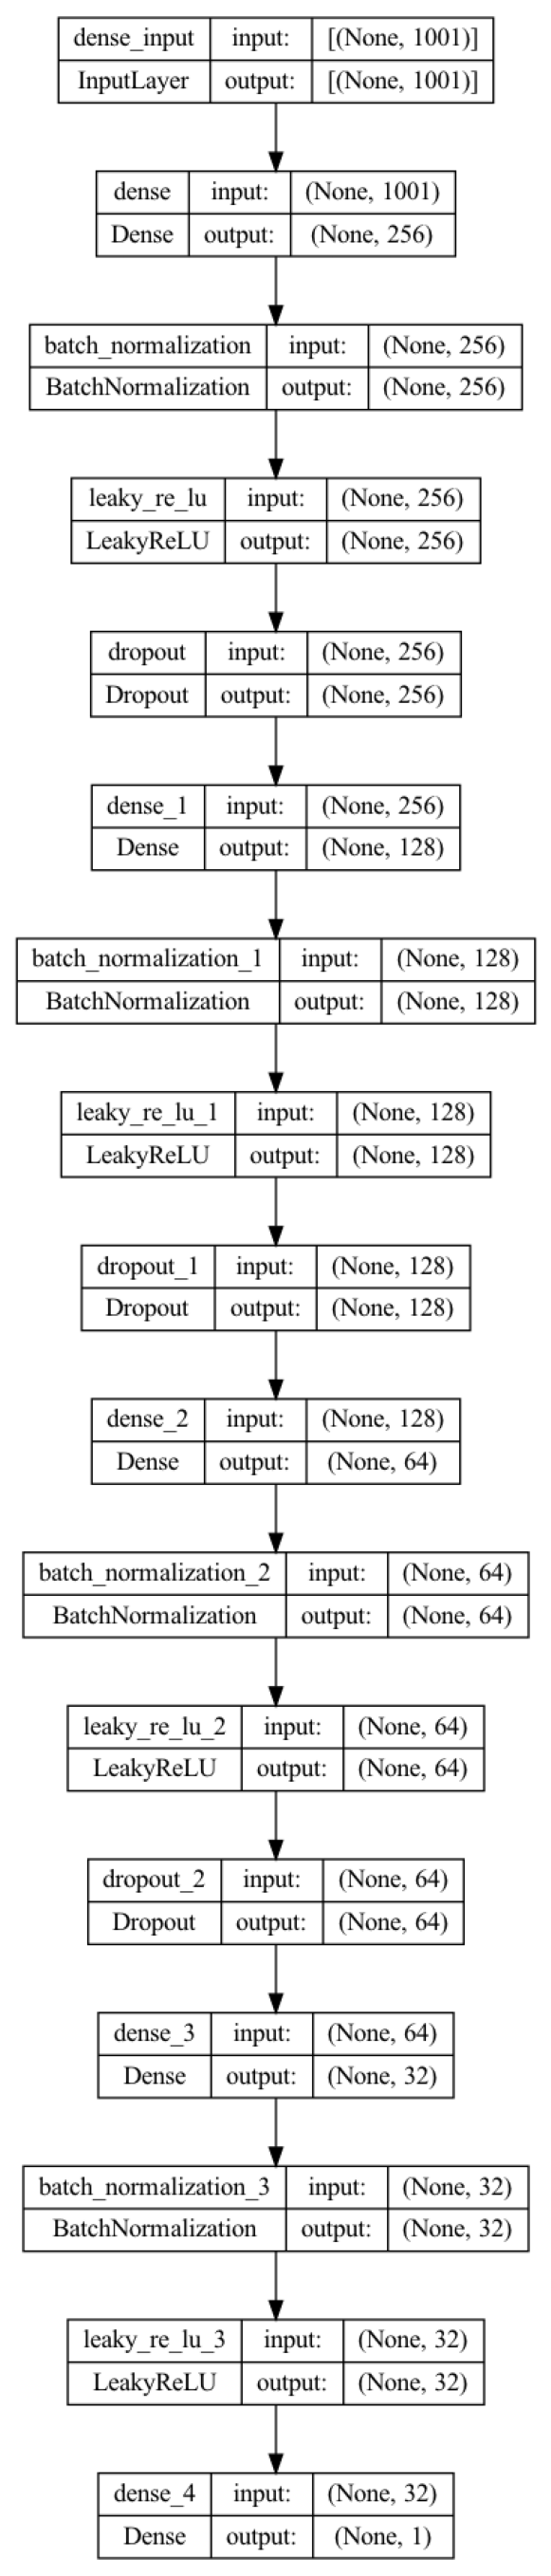

In [47]:

# Display the model structure image
plt.figure(figsize=(10, 35))
img = plt.imread('model_structure.png')
plt.imshow(img)
plt.axis('off')
plt.show()

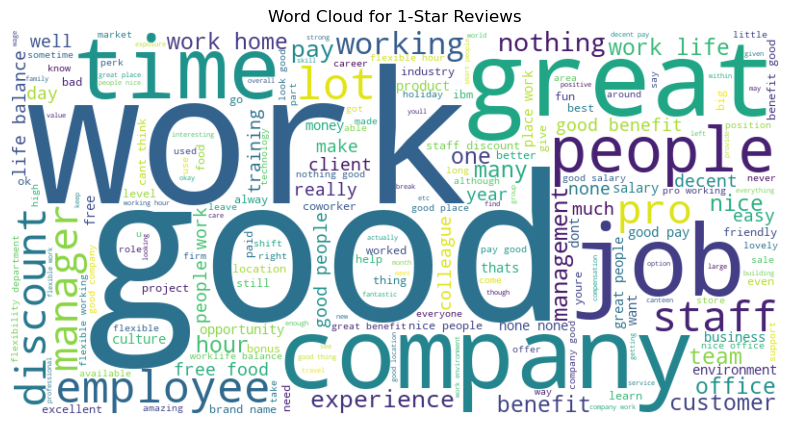

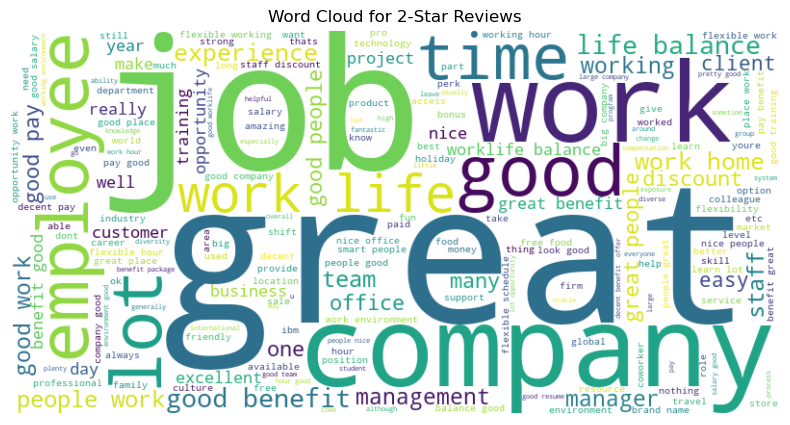

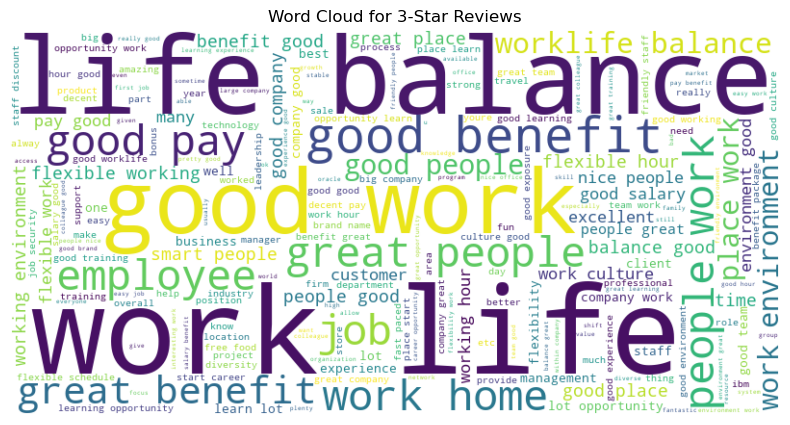

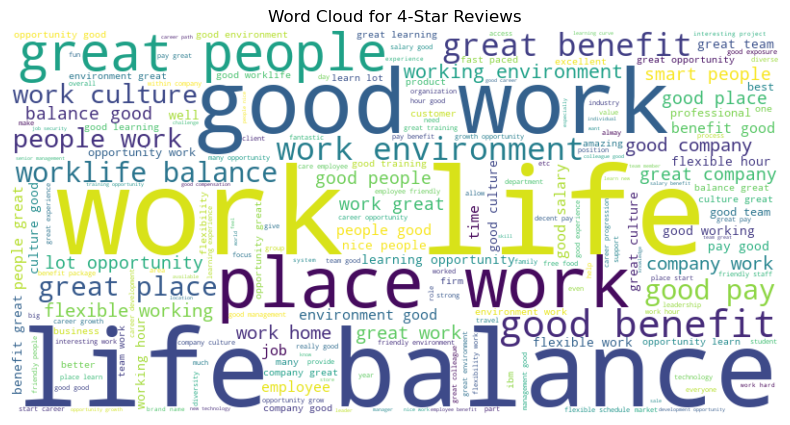

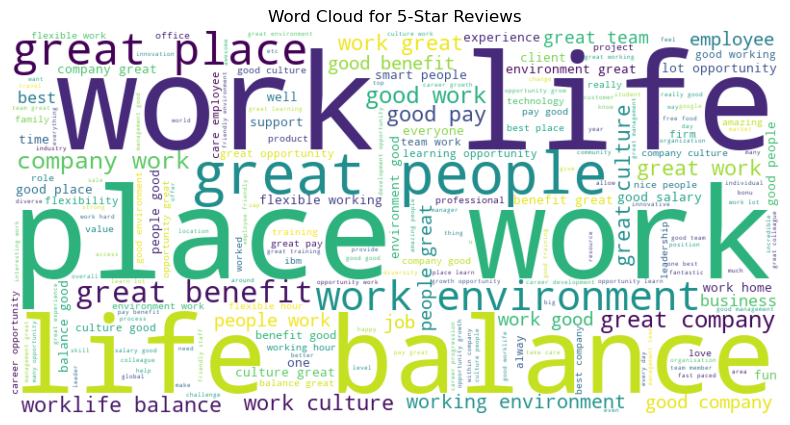

In [48]:
from wordcloud import WordCloud

for star_rating in range(1, 6):
    # Combine all 'pros' text for the current star rating
    review_text = ' '.join(df_train[df_train['rating'] == star_rating]['pros'].tolist())
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(review_text)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {star_rating}-Star Reviews')
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

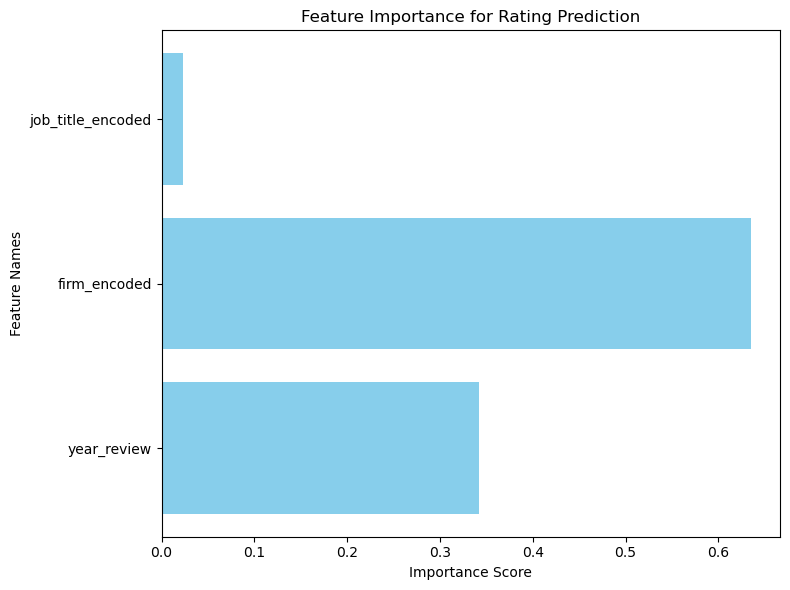

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Encode categorical features
label_encoder = LabelEncoder()
df_train['firm_encoded'] = label_encoder.fit_transform(df_train['firm'].fillna(''))
df_train['job_title_encoded'] = label_encoder.fit_transform(df_train['job_title'].fillna(''))

# Define features and target variable
feature_columns = ['year_review', 'firm_encoded', 'job_title_encoded']
target_column = 'rating'  # Predicting the 'rating'

# Prepare data for training and testing
X = df_train[feature_columns]
y = df_train[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
random_forest = RandomForestRegressor(n_estimators=100, max_depth=7, random_state=42)
random_forest.fit(X_train, y_train)

# Extract feature importance scores
feature_importances = random_forest.feature_importances_

# Visualize feature importance
plt.figure(figsize=(8, 6))
plt.barh(feature_columns, feature_importances, color='skyblue')
plt.title("Feature Importance for Rating Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature Names")
plt.tight_layout()  # Adjust layout to fit title and labels
plt.show()

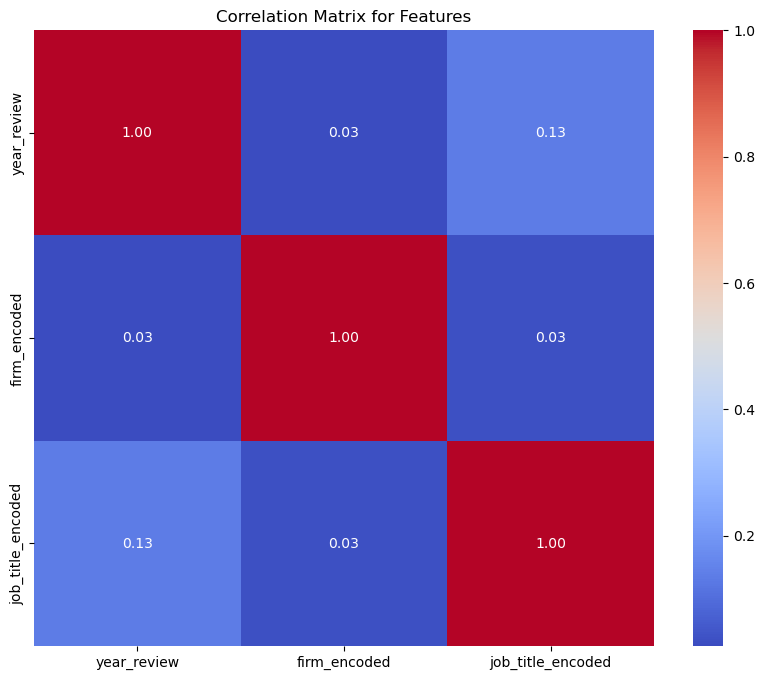

In [50]:
correlation_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Features')
plt.show()

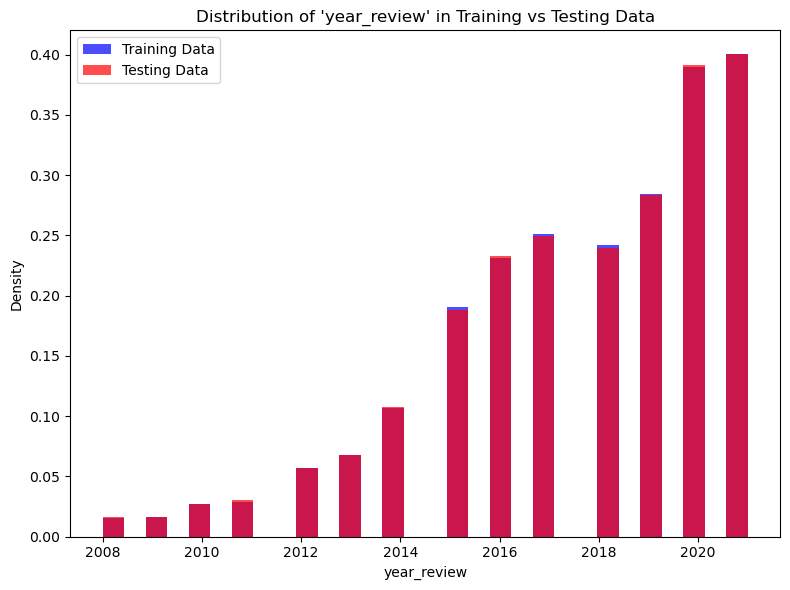

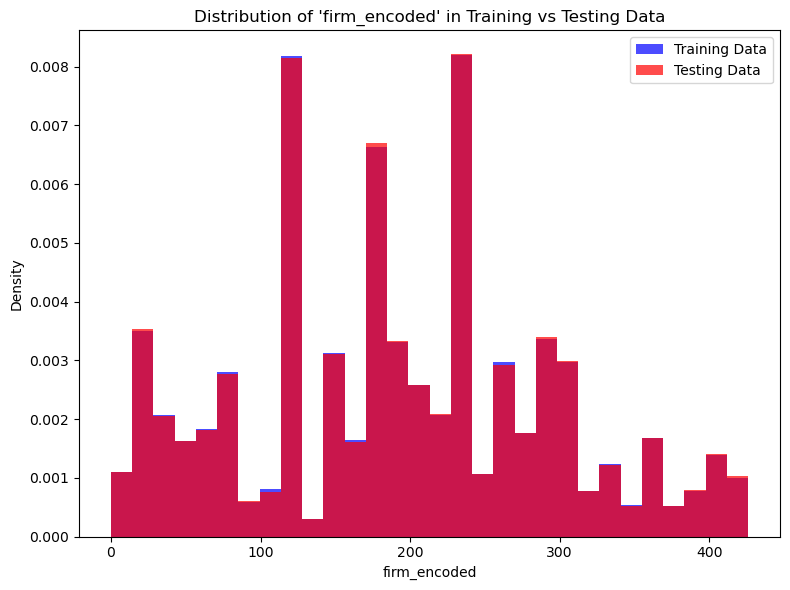

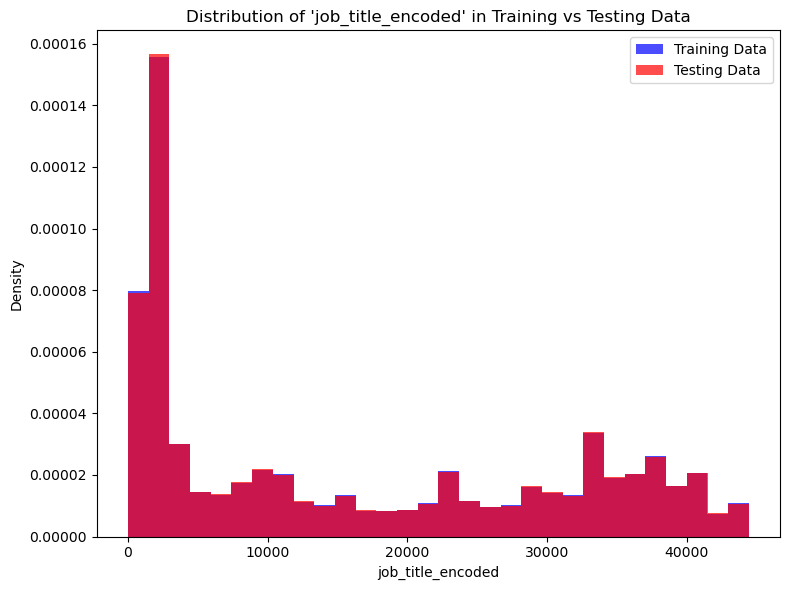

In [51]:
# Plot the distribution of each feature in both the training and test datasets
# Visualize the distribution of each feature in the training and testing datasets
for feature_name in feature_columns:  # Renamed 'features' to 'feature_columns' for consistency
    plt.figure(figsize=(8, 6))
    
    # Plot the distribution of the feature in the training data
    plt.hist(
        X_train[feature_name], 
        bins=30, 
        alpha=0.7, 
        color='blue', 
        label='Training Data', 
        density=True
    )
    
    # Plot the distribution of the feature in the test data
    plt.hist(
        X_test[feature_name], 
        bins=30, 
        alpha=0.7, 
        color='red', 
        label='Testing Data', 
        density=True
    )
    
    # Add title and labels
    plt.title(f"Distribution of '{feature_name}' in Training vs Testing Data")
    plt.xlabel(f"{feature_name}")
    plt.ylabel("Density")
    plt.legend()  # Show the legend to distinguish between Train and Test data
    plt.tight_layout()  # Ensure the layout fits nicely
    plt.show()


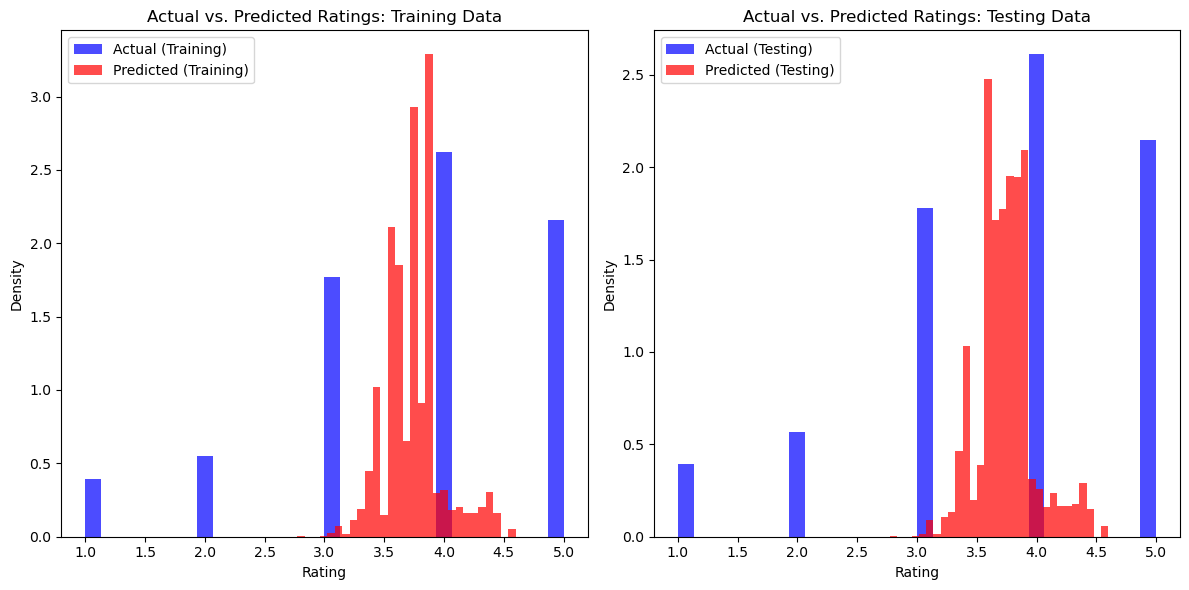

In [53]:
# Predict ratings for both training and test sets
train_predictions = random_forest.predict(X_train)
test_predictions = random_forest.predict(X_test)

# Plot the distribution of actual vs. predicted ratings for training and test datasets
plt.figure(figsize=(12, 6))

# Plot for the training data
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, alpha=0.7, color='blue', label='Actual (Training)', density=True)
plt.hist(train_predictions, bins=30, alpha=0.7, color='red', label='Predicted (Training)', density=True)
plt.title("Actual vs. Predicted Ratings: Training Data")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()

# Plot for the test data
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, alpha=0.7, color='blue', label='Actual (Testing)', density=True)
plt.hist(test_predictions, bins=30, alpha=0.7, color='red', label='Predicted (Testing)', density=True)
plt.title("Actual vs. Predicted Ratings: Testing Data")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()

# Adjust layout for better visualization
plt.tight_layout()
plt.show()


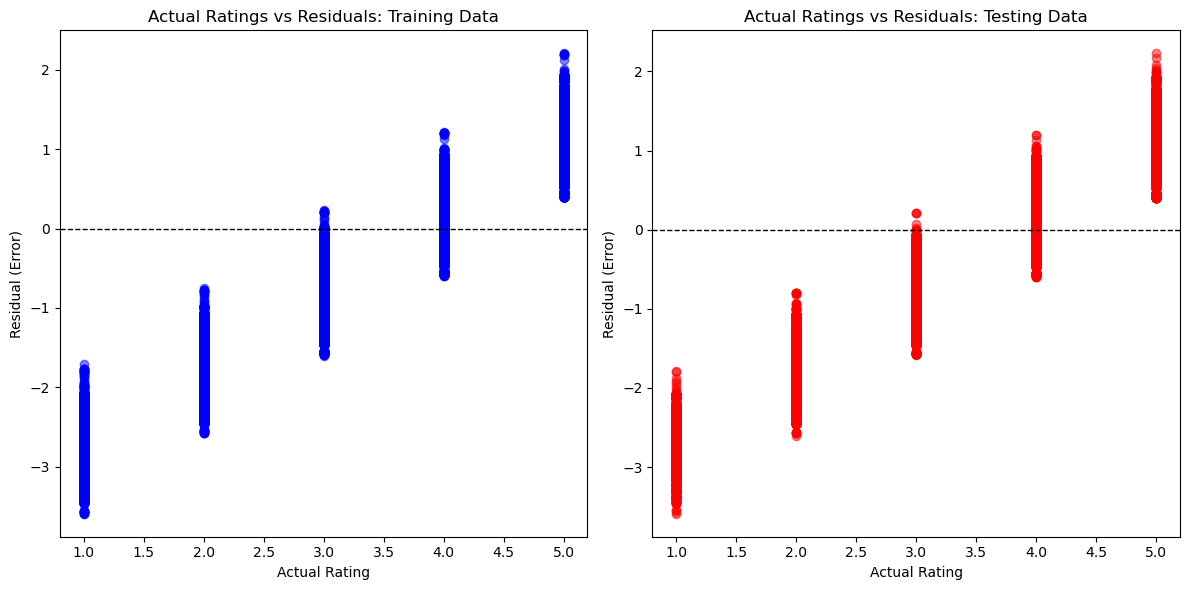

In [54]:
# Calculate residuals (errors) for training and testing datasets
train_residuals = y_train - train_predictions
test_residuals = y_test - test_predictions

# Visualize the distribution of residuals
plt.figure(figsize=(12, 6))

# Residual plot for training data
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_residuals, alpha=0.5, color='blue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at 0
plt.title("Actual Ratings vs Residuals: Training Data")
plt.xlabel("Actual Rating")
plt.ylabel("Residual (Error)")

# Residual plot for testing data
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_residuals, alpha=0.5, color='red')
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # Reference line at 0
plt.title("Actual Ratings vs Residuals: Testing Data")
plt.xlabel("Actual Rating")
plt.ylabel("Residual (Error)")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


In [55]:
def get_top_phrases_by_rating(df, rating_threshold):
    subset = df[df['rating'] >= rating_threshold]
    combined_text = ' '.join(subset['pros'] + ' ' + subset['cons'] + ' ' + subset['headline'])
    word_freq = pd.Series(combined_text.split()).value_counts().head(10)
    return word_freq

high_rating_phrases = get_top_phrases_by_rating(df_train, 4)
low_rating_phrases = get_top_phrases_by_rating(df_train, 2)

print("Top phrases in high-rated firms:")
print(high_rating_phrases)
print("\nTop phrases in low-rated firms:")
print(low_rating_phrases)

Top phrases in high-rated firms:
work           248368
good           202102
great          197599
company        124557
people          84598
place           76033
opportunity     65366
working         59299
hour            55052
lot             54680
Name: count, dtype: int64

Top phrases in low-rated firms:
work           358793
good           309259
great          250627
company        173852
people         135448
place           98262
opportunity     91781
management      88760
hour            88193
working         87336
Name: count, dtype: int64



=== Medium Rated Firms ===
Top Pros: [('good', 135574), ('work', 116435), ('great', 86490), ('people', 55525), ('benefits', 39715), ('company', 35581), ('environment', 31546), ('opportunities', 29698), ('working', 28386), ('life', 27891)]
Top Cons: [('work', 73507), ('management', 37321), ('hours', 36969), ('long', 27701), ('pay', 26397), ('company', 24463), ('life', 22969), ('people', 21708), ('time', 20808), ('balance', 20277)]

=== Low Rated Firms ===
Top Pros: [('good', 24406), ('work', 17873), ('great', 11024), ('people', 10598), ('benefits', 7689), ('company', 6677), ('nice', 5289), ('pay', 5244), ('working', 5111), ('job', 4347)]
Top Cons: [('work', 27668), ('management', 26298), ('people', 15191), ('company', 12934), ('pay', 10983), ('staff', 10689), ('managers', 10510), ('employees', 10105), ('time', 9444), ('hours', 9041)]

=== High Rated Firms ===
Top Pros: [('work', 62408), ('great', 58361), ('good', 48450), ('people', 28143), ('company', 24747), ('culture', 19808), ('bene

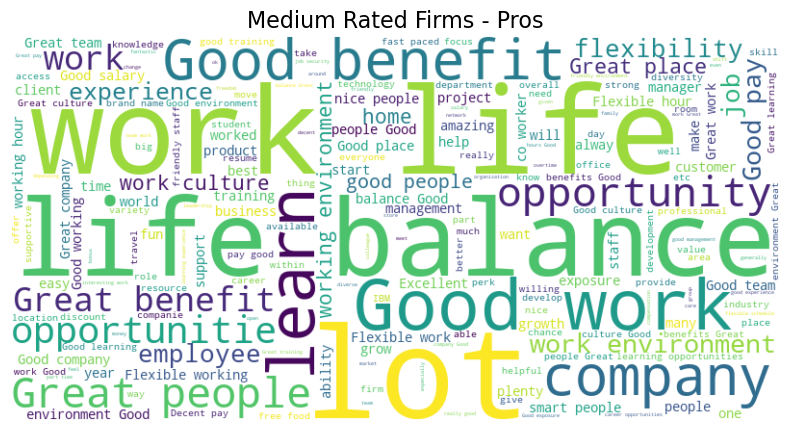

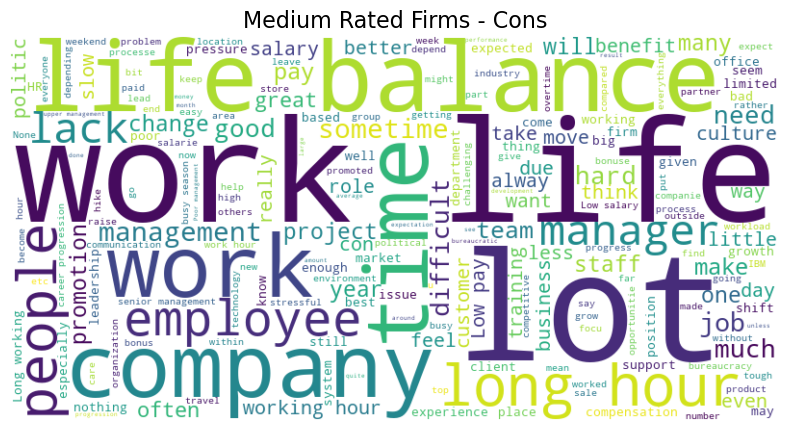

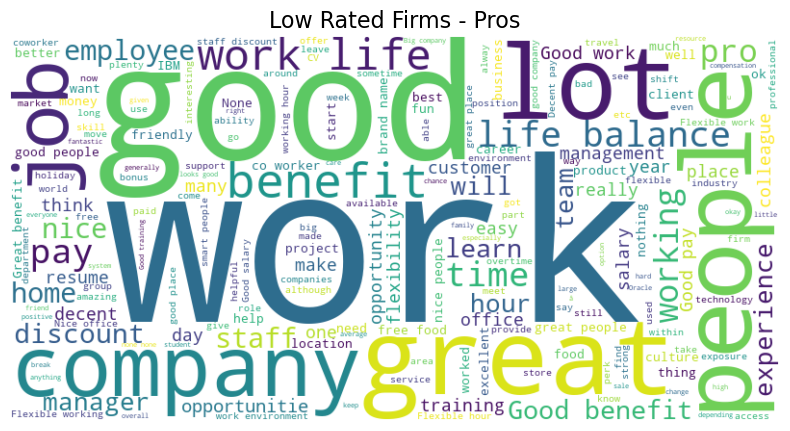

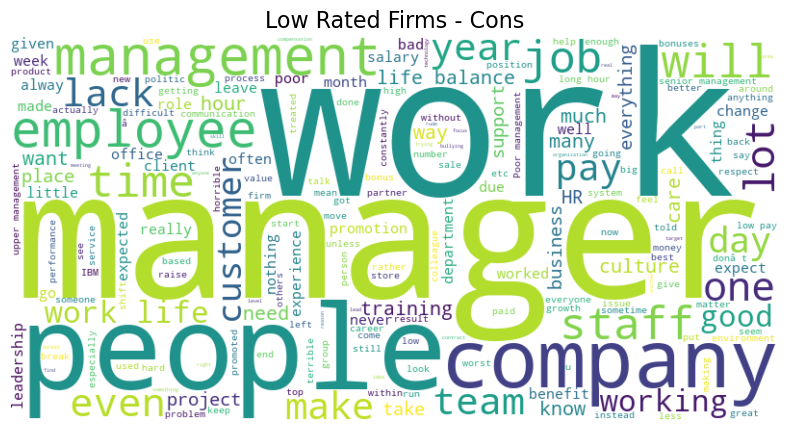

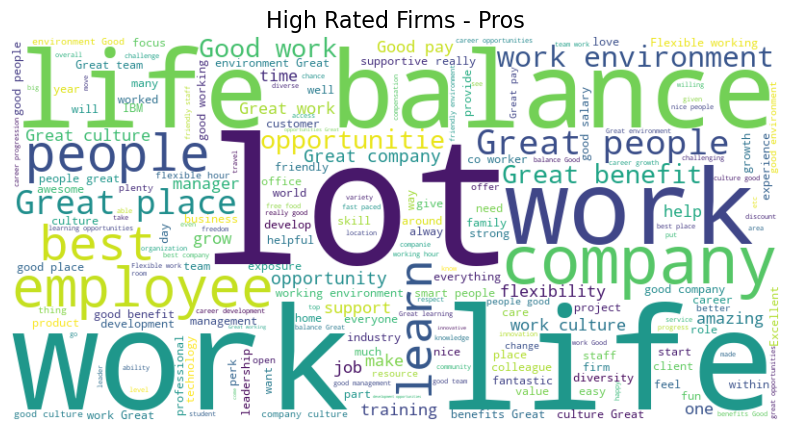

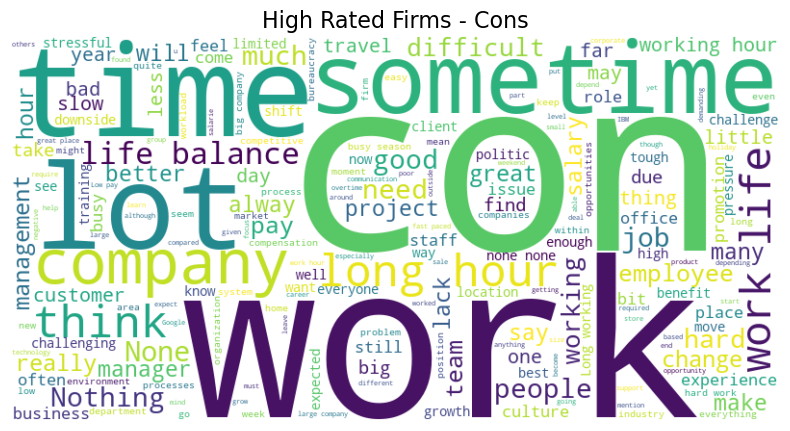

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

# Load data
df = pd.read_csv(large_train)

# Categorize firms by average rating (low: 1-2, medium: 3-4, high: 5)
df['rating_group'] = pd.cut(df['rating'], bins=[0, 2, 4, 5], labels=['Low', 'Medium', 'High'])

# Function to extract top words/themes
def extract_themes(text_column, top_n=10):
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(text_column.dropna())
    word_sum = word_counts.sum(axis=0)
    words_freq = [(word, word_sum[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_n]
    return words_freq

# Analyze themes for pros and cons by rating group
themes = {}
for group in df['rating_group'].unique():
    group_data = df[df['rating_group'] == group]
    pros_themes = extract_themes(group_data['pros'], top_n=10)
    cons_themes = extract_themes(group_data['cons'], top_n=10)
    themes[group] = {'pros': pros_themes, 'cons': cons_themes}

# Display results in a table
for group, data in themes.items():
    print(f"\n=== {group} Rated Firms ===")
    print("Top Pros:", data['pros'])
    print("Top Cons:", data['cons'])

# Optional: Create word clouds for visualization
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

for group in df['rating_group'].unique():
    group_data = df[df['rating_group'] == group]
    plot_wordcloud(group_data['pros'].dropna(), f"{group} Rated Firms - Pros")
    plot_wordcloud(group_data['cons'].dropna(), f"{group} Rated Firms - Cons")
